<a href="https://colab.research.google.com/github/YuvrajGoswami/Vehicle-management-System/blob/main/Face_recognation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install virtualenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 26.2 MB/s eta 0:00:00


In [6]:
!virtualenv myenv

created virtual environment CPython3.10.12.final.0-64 in 2525ms
  creator CPython3Posix(dest=/content/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==75.1.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [7]:
!source myenv/bin/activate

In [8]:
!pip install insightface

  Using cached insightface-0.7.3.tar.gz (439 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.5 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055394 sha256=3399a26038057f0c47a5d1e57c3da3a5301fe340b91ce3beba4cd2137307c757
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [9]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


In [14]:
import cv2
import os
import pandas as pd
import numpy as np
import re   #regular expression
import matplotlib.pyplot as plt

from insightface.app import FaceAnalysis
from google.colab.patches import cv2_imshow
import onnxruntime as ort
from sklearn.metrics import pairwise

In [11]:
faceapp=FaceAnalysis(name='buffalo_l',
                     root='/content/drive/MyDrive/face_recognation_system/models',providers=['CPUExecutionProvider'])

faceapp.prepare(ctx_id=0, det_size=(640,640), det_thresh=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/drive/MyDrive/face_recognation_system/models/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/drive/MyDrive/face_recognation_system/models/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/drive/MyDrive/face_recognation_system/models/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /content/drive/MyDrive/face_recognation_system/models/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find m

## Extract Facial Features and Label

In [16]:
listdir=os.listdir('/content/drive/MyDrive/face_recognation_system/data')
print(listdir)

['002-Employee-brinil-jhon', '001-Employee-Gokul-j']


In [12]:
def clean_name(string):
    string = re.sub(r'[^A-Za-z]',' ',string)
    string = string.upper()
    return string

In [17]:
person_info=[]

for folder_name in listdir:
    # Split the folder name into parts
    split_name = folder_name.split('-')

    # Check if there are at least 3 parts: ID, Role, and Name
    if len(split_name) < 3:
        print(f"Skipping '{folder_name}' due to unexpected format.")
        continue

    # Get the first two parts as ID and role
    IDno = split_name[0]
    role = split_name[1]

    # Join the remaining parts as the name (ensures multi-part names are preserved)
    name = ' '.join(split_name[2:])  # Using space as separator instead of hyphen

    # Clean the name using the defined function
    name = clean_name(name)
    role=clean_name(role)

    # # Print the ID, role, and cleaned name
    # print(f'ID-Number: {IDno}\tRole: {role}\tName: {name}')

    #path of the images
    img_files = os.listdir(path=f'/content/drive/MyDrive/face_recognation_system/data/{folder_name}')
    for file in img_files:
      path= f'/content/drive/MyDrive/face_recognation_system/data/{folder_name}/{file}'
      #step1:read the img
      img_arr = cv2.imread(path)

      #step2: get the info
      result = faceapp.get(img_arr,max_num=1)    #return list

      if len(result) > 0:
        #step3:extract the facial embedding
        res=result[0]
        embeddings = res['embedding']

        #step4: save all information in a list
        person_info.append([IDno,name,role,embeddings])

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [35]:
dataframe=pd.DataFrame(person_info,columns=['ID-Number','Name','Role','Facial_Features'])
print(dataframe.head(5))

  ID-Number         Name      Role  \
0       002  BRINIL JHON  EMPLOYEE   
1       002  BRINIL JHON  EMPLOYEE   
2       002  BRINIL JHON  EMPLOYEE   
3       002  BRINIL JHON  EMPLOYEE   
4       002  BRINIL JHON  EMPLOYEE   

                                     Facial_Features  
0  [0.1608749, 1.7368813, -1.1490161, 1.663376, 0...  
1  [0.42803138, 1.5374688, -1.8009486, 1.5362829,...  
2  [0.42934984, 1.4359636, -1.3666556, 1.3741276,...  
3  [0.5839606, 1.3094258, -1.6811714, 1.9485161, ...  
4  [0.5307296, 1.5936162, -1.3837559, 1.5376147, ...  


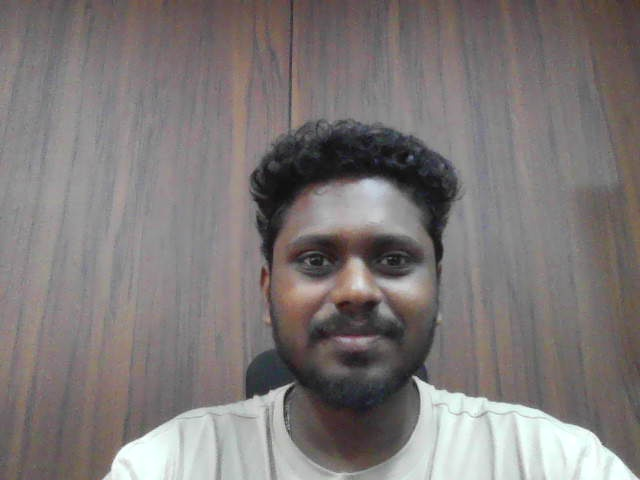

In [19]:
img_test=cv2.imread('/content/drive/MyDrive/face_recognation_system/data/001-Employee-Gokul-j/Gokul_0.jpg')

cv2_imshow(img_test)

In [20]:
#Extract feature from test image
res_test= faceapp.get(img_test, max_num=0)
for i, rt in enumerate(res_test):
  bbox=rt['bbox'].astype(int)
  score=int(rt['det_score']*100)
  embed_test=rt['embedding']

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [21]:
len(embed_test)

512

In [22]:
dataframe.head(5)

,ID-Number,Name,Role,Facial_Features
0,002,BRINIL JHON,EMPLOYEE,"[0.1608749, 1.7368813, -1.1490161, 1.663376, 0..."
1,002,BRINIL JHON,EMPLOYEE,"[0.42803138, 1.5374688, -1.8009486, 1.5362829,..."
2,002,BRINIL JHON,EMPLOYEE,"[0.42934984, 1.4359636, -1.3666556, 1.3741276,..."
3,002,BRINIL JHON,EMPLOYEE,"[0.5839606, 1.3094258, -1.6811714, 1.9485161, ..."
4,002,BRINIL JHON,EMPLOYEE,"[0.5307296, 1.5936162, -1.3837559, 1.5376147, ..."


In [23]:
X_list = dataframe['Facial_Features'].tolist()
X= np.array(X_list)
y= embed_test

In [24]:
X.shape

(200, 512)

In [25]:
y= embed_test.reshape(1,512)

equlidean_distance = pairwise.euclidean_distances(X,y)
manhattan_distance = pairwise.manhattan_distances(X,y)
cosine_similar = pairwise.cosine_similarity(X,y)

In [26]:
data_search = dataframe.copy()
data_search['equlidean'] = equlidean_distance
data_search['manhattan'] = manhattan_distance
data_search['cosine'] = cosine_similar

In [31]:
data_search.head(5)

,ID-Number,Name,Role,Facial_Features,equlidean,manhattan,cosine
0,002,BRINIL JHON,EMPLOYEE,"[0.1608749, 1.7368813, -1.1490161, 1.663376, 0...",26.794712,488.993699,0.299892
1,002,BRINIL JHON,EMPLOYEE,"[0.42803138, 1.5374688, -1.8009486, 1.5362829,...",26.548981,483.913619,0.287523
2,002,BRINIL JHON,EMPLOYEE,"[0.42934984, 1.4359636, -1.3666556, 1.3741276,...",26.770588,483.747399,0.303038
3,002,BRINIL JHON,EMPLOYEE,"[0.5839606, 1.3094258, -1.6811714, 1.9485161, ...",26.766626,486.591888,0.295776
4,002,BRINIL JHON,EMPLOYEE,"[0.5307296, 1.5936162, -1.3837559, 1.5376147, ...",26.528515,485.589881,0.325632


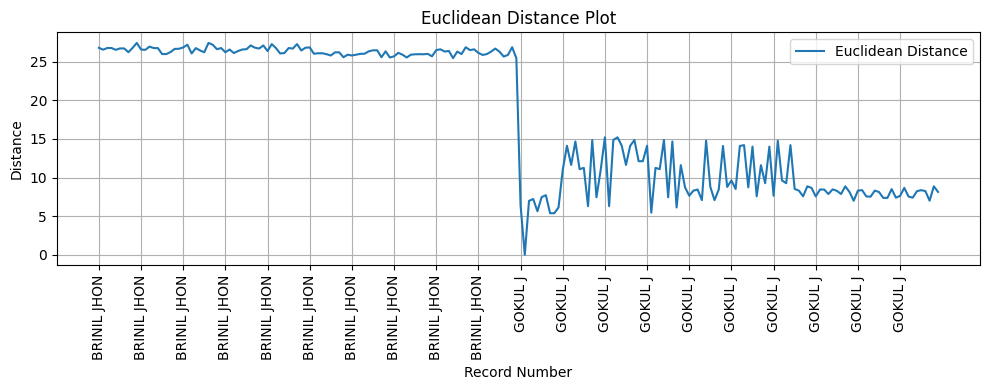

In [34]:
plt.figure(figsize=(10, 4))
plt.subplot(3,1,1)
plt.plot(data_search['equlidean'], label='Euclidean Distance')

num_labels = len(data_search['equlidean'])
interval = max(1, num_labels // 20)
plt.xticks(ticks=list(range(0, num_labels, interval)), labels=data_search['Name'][::interval], rotation=90)

plt.xlabel('Record Number')
plt.ylabel('Distance')
plt.grid()
plt.title('Euclidean Distance Plot')
plt.legend()
plt.tight_layout()



plt.figure(figsize=(10, 4))
plt.subplot(3,1,2)
plt.plot(data_search['manhattan'], label='manhattan Distance')

num_labels = len(data_search['manhattan'])
interval = max(1, num_labels // 20)
plt.xticks(ticks=list(range(0, num_labels, interval)), labels=data_search['Name'][::interval], rotation=90)

plt.xlabel('Name of the person')
plt.ylabel('Distance')
plt.grid()
plt.title('Euclidean Distance Plot')
plt.legend()
plt.tight_layout()


plt.show()
